# **Jacob Shearer - Excercise set 4**

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random

**Question 1:**

Part (a):
$$ \int_{20}^{500}c\cdot F(E) dE = c \cdot 4.14575\cdot10^{-6} = 1$$
<br/>
Therefore, to renormalize the distribution over the interval 20-500 MeV, we would need a normalization constant of $c = 4.14575\cdot10^{6}$.

In [2]:
def make_photons(num_photons):
    distribution = lambda E, a, k, E_c, c: c*k*E**(-a)*np.e**(-E/E_c)
    a = 1.87
    E_c = 81
    k = 10e-4
    c = 4.14575e6
    energies = np.array([])
    num_accepted = 0
    while num_accepted < num_photons:
        energy = random.uniform(20, 500)
        probability = distribution(energy, a, k, E_c, c)
        if probability > random.random():
            energies = np.append(energies, energy)
            num_accepted += 1
    
    return energies

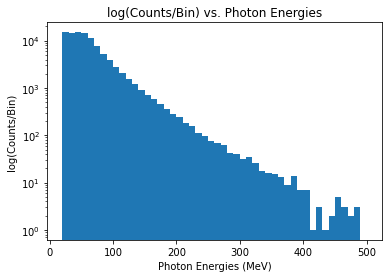

In [3]:
energies = make_photons(100000)
bin_stepsize = 10
energy_bins = np.arange(20, 500 + bin_stepsize, bin_stepsize)
plt.hist(energies, bins=energy_bins, log=True)
plt.title('log(Counts/Bin) vs. Photon Energies')
plt.xlabel('Photon Energies (MeV)')
plt.ylabel('log(Counts/Bin)')
plt.show()
# plt.plot(energy_bins, np.log(distribution(energy_bins, a, k, E_c, c)))
# plt.show()
# what is a log-log histogram? log bins? Ask about this...

Part (b):
<br/>
I'll use the following expressions to convert the rightward ascension and declination angles to x and y coordinates:
<br/>
$$ x = rcos(\delta)cos(\alpha)$$
$$ y = rcos(\delta)sin(\alpha)$$
<br/>
where $\alpha$ is the rightward ascention angle and $\delta$ is the declination angle. I'll also assume that the radial coordinate $r = 1$.

In [4]:
# Part (b):
def angles_to_x(r, RA, DEC):
    DEC = DEC * np.pi/180
    RA = RA * np.pi/180
    return r*np.cos(DEC)*np.cos(RA)

def angles_to_y(r, RA, DEC):
    DEC = DEC * np.pi/180
    RA = RA * np.pi/180
    return r*np.cos(DEC)*np.sin(RA)

def make_positions(energies, r, RA, DEC):
    distribution = lambda pos, sigma, energy, mue:(1/np.sqrt(2*np.pi*sigma**2))*np.e**(-((pos-mue)**2)/(2*mue**2))
    mue_x = angles_to_x(1, RA, DEC)
    mue_y = angles_to_y(1, RA, DEC)
    RA_array = np.array([])
    DEC_array = np.array([])
    for energy in energies:
        sigma = (energy/100)**-0.8
        while True:
            random_RA = random.uniform(0, 360)
            random_DEC = random.uniform(-90,90)
            random_x = angles_to_x(1, random_RA, random_DEC)
            random_y = angles_to_y(1, random_RA, random_DEC)
            x_prob = distribution(random_x, sigma, energy, mue_x)
            y_prob = distribution(random_y, sigma, energy, mue_y)
            if x_prob > random.random() and y_prob > random.random():
                RA_array = np.append(RA_array, random_RA)
                DEC_array = np.append(DEC_array, random_DEC)
                break
    
    return RA_array, DEC_array

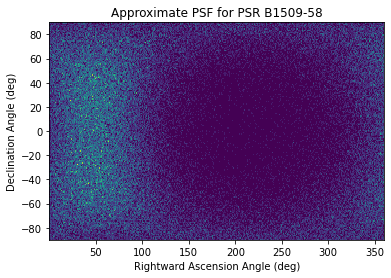

In [5]:
energies = np.zeros(100000) + 100
RA = 48.04
DEC = -30.92
RA_array, DEC_array = make_positions(energies, 1, RA, DEC)

plt.hist2d(RA_array, DEC_array, bins=(360, 180))
plt.xlabel('Rightward Ascension Angle (deg)')
plt.ylabel('Declination Angle (deg)')
plt.title('Approximate PSF for PSR B1509-58')
plt.show()

In [6]:
# Part (c):
RA = 48.04
DEC = -30.92
energies = make_photons(100000)
RA_array, DEC_array = make_positions(energies, 1, RA, DEC)

Part (c):


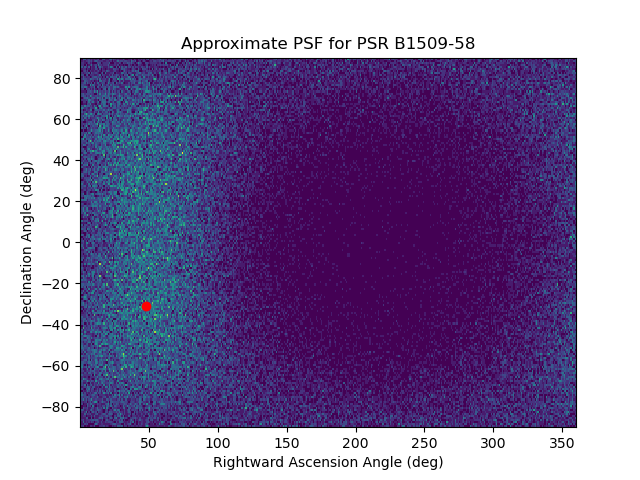

The red dot is the location of the pulsar.


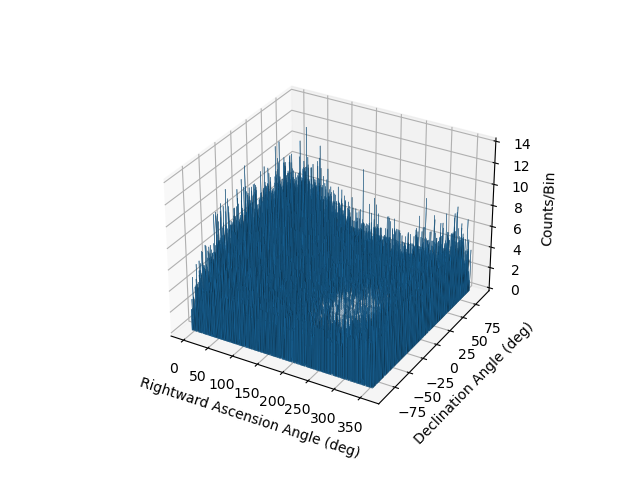

In [11]:
print('Part (c):')
%matplotlib widget
plt.hist2d(RA_array, DEC_array, bins=(360, 180))
plt.scatter([RA], [DEC], c='r')
plt.xlabel('Rightward Ascension Angle (deg)')
plt.ylabel('Declination Angle (deg)')
plt.title('Approximate PSF for PSR B1509-58')
plt.show()
print('The red dot is the location of the pulsar.')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, x_edges, y_edges = np.histogram2d(RA_array, DEC_array, bins=[np.arange(0, 360, 1), np.arange(-90, 90, 1)])
xpos, ypos = np.meshgrid(x_edges[:-1] + 0.25, y_edges[:-1] + 0.25, indexing = 'ij')
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.set_xlabel('Rightward Ascension Angle (deg)')
ax.set_ylabel('Declination Angle (deg)')
ax.set_zlabel('Counts/Bin')
plt.show()